In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse import csr_matrix

In [ ]:
!pip install scikit-surprise
from surprise import SVD,KNNBasic,SVDpp
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633964 sha256=73a71f2b50d2124a8be52ebb349d194f923bc4ae9fc88e3652e8b23df2848dc3
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
links = pd.read_csv('/content/drive/MyDrive/ml-25m/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/ml-25m/movies.csv')
tags = pd.read_csv('/content/drive/MyDrive/ml-25m/tags.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ml-25m/ratings.csv')


In [ ]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
62418,209157,6671244,499546.0
62419,209159,297986,63407.0
62420,209163,6755366,553036.0
62421,209169,249603,162892.0


In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [ ]:
tags

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455
...,...,...,...,...
1093355,162521,66934,Neil Patrick Harris,1427311611
1093356,162521,103341,cornetto trilogy,1427311259
1093357,162534,189169,comedy,1527518175
1093358,162534,189169,disabled,1527518181


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


**Exploratory Data analysis**

In [ ]:
#Preparing the dataset as per the requirement
#Checking null values in the dataset 
#checking for any outliers 
#analysing distribution of ratings

In [ ]:
null_values_r = ratings.isnull().sum().sum()
print(f"Number of null values in the rating: {null_values_r}")

Number of null values in the rating: 0


In [ ]:
null_values_l = links.isnull().sum().sum()
print(f"Number of null values in the links: {null_values_l}")

Number of null values in the links: 107


In [ ]:
# dropping the null values in links
links.dropna(inplace = True)

In [ ]:
null_values_m = movies.isnull().sum().sum()
print(f"Number of null values in the tags: {null_values_m}")

Number of null values in the tags: 0


In [ ]:
null_values_t = tags.isnull().sum().sum()
print(f"Number of null values in the tags: {null_values_t}")

Number of null values in the tags: 16


In [ ]:
#dropping null values in tags
tags.dropna(inplace = True) 

In [ ]:
#merging ratings and movies on movieid to form a dataset
dataset= pd.merge(movies,ratings, on ='movieId', how ="outer")
dataset

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,3.5,1.141416e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1.439472e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,3.0,1.573944e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.586259e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,8.904925e+08
...,...,...,...,...,...,...
25003466,209157,We (2018),Drama,119571.0,1.5,1.574281e+09
25003467,209159,Window of the Soul (2001),Documentary,115835.0,3.0,1.574281e+09
25003468,209163,Bad Poems (2018),Comedy|Drama,6964.0,4.5,1.574285e+09
25003469,209169,A Girl Thing (2001),(no genres listed),119571.0,3.0,1.574292e+09


In [ ]:
# checking for an outlier in ratings given by the user
dataset['rating'].describe().T

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
# list of all the movies which are rated 5 by the user
dataset[dataset['rating'] == 5]

,movieId,title,genres,userId,rating,timestamp
10,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,36.0,5.0,8.571314e+08
22,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,75.0,5.0,1.537208e+09
25,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,86.0,5.0,9.454628e+08
26,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,90.0,5.0,8.635380e+08
27,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,93.0,5.0,1.496543e+09
...,...,...,...,...,...,...
25003414,208939,Klaus (2019),Adventure|Animation|Children|Comedy,53837.0,5.0,1.574065e+09
25003415,208939,Klaus (2019),Adventure|Animation|Children|Comedy,113924.0,5.0,1.574032e+09
25003416,208939,Klaus (2019),Adventure|Animation|Children|Comedy,117863.0,5.0,1.574137e+09
25003443,209085,The Mistletoe Secret (2019),Romance,99091.0,5.0,1.574120e+09


In [ ]:
# information about user 791 , all the movies he have voted
dataset[dataset['userId'] == 791.0]

,movieId,title,genres,userId,rating,timestamp
258,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,791.0,4.5,1.515175e+09
10767904,2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,791.0,4.5,1.515185e+09
13008250,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,791.0,4.5,1.515175e+09
15208073,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,791.0,4.5,1.515175e+09
15839245,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,791.0,4.5,1.515175e+09
15885934,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,791.0,4.5,1.515185e+09
16064224,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,791.0,4.5,1.515175e+09
16308892,5218,Ice Age (2002),Adventure|Animation|Children|Comedy,791.0,4.5,1.515185e+09
17004973,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,791.0,4.5,1.515175e+09
18126551,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,791.0,4.5,1.515175e+09


In [ ]:
# 10 most popular genres , sorted based on the total nymber of user ratings
popular_genre = (movies.genres.str.split('|').explode().value_counts() .sort_values(ascending=False))
x= popular_genre.head(10)
print( 'most popular 10 genres ammong all are :\n {}'.format (x))

most popular 10 genres ammong all are :
 Drama                 25606
Comedy                16870
Thriller               8654
Romance                7719
Action                 7348
Horror                 5989
Documentary            5605
Crime                  5319
(no genres listed)     5062
Adventure              4145
Name: genres, dtype: int64


In [ ]:
# 10 most popular movies , sorted based on the total nymber of user ratings
popular_title = (dataset.title.str.split('|').explode().value_counts() .sort_values(ascending=False))
x= popular_title.head(10)
print( 'most popular 10 movies which are mostly rated by user :\n {}'.format (x))

most popular 10 movies which are mostly rated by user :
 Forrest Gump (1994)                          81491
Shawshank Redemption, The (1994)             81482
Pulp Fiction (1994)                          79672
Silence of the Lambs, The (1991)             74127
Matrix, The (1999)                           72674
Star Wars: Episode IV - A New Hope (1977)    68717
Jurassic Park (1993)                         64144
Schindler's List (1993)                      60411
Braveheart (1995)                            59184
Fight Club (1999)                            58773
Name: title, dtype: int64


In [ ]:
# count of ratings with the interval of 0.5
rating_count = pd.DataFrame(dataset.groupby(['rating']).size(), columns=['count'])
rating_count

,count
rating,
0.5,393068
1.0,776815
1.5,399490
2.0,1640868
2.5,1262797
3.0,4896928
3.5,3177318
4.0,6639798
4.5,2200539


Text(0, 0.5, 'number of ratings')

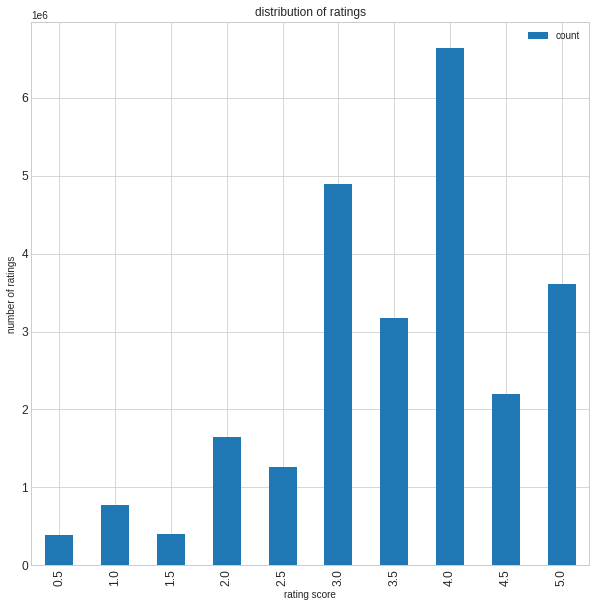

In [ ]:
ratings_bar = rating_count.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(10, 10),
    title='distribution of ratings',
    fontsize=12)

ratings_bar.set_xlabel("rating score")
ratings_bar.set_ylabel("number of ratings")

it can be observed that most of the movies got rating inbetween 3 to 4.

In [ ]:
#count of number of ratings given by the user in descending order
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
72314,72315,32202
80973,80974,9178
137292,137293,8913
33843,33844,7919
20054,20055,7488
109730,109731,6647
92045,92046,6564
49402,49403,6553
30878,30879,5693
115101,115102,5649


In [ ]:
print(dataset.genres.unique().tolist())

['Adventure|Animation|Children|Comedy|Fantasy', 'Adventure|Children|Fantasy', 'Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller', 'Adventure|Children', 'Action', 'Action|Adventure|Thriller', 'Comedy|Horror', 'Adventure|Animation|Children', 'Drama', 'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance', 'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller', 'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi', 'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi', 'Mystery|Sci-Fi|Thriller', 'Adventure|Romance|IMAX', 'Documentary|IMAX', 'Children|Comedy', 'Drama|War', 'Action|Crime|Drama', 'Action|Adventure|Fantasy', 'Comedy|Drama|Thriller', 'Mystery|Thriller', 'Animation|Children|Drama|Musical|Romance', 'Crime|Mystery|Thriller', 'Action|Drama|Thriller', 'Adventure|Drama', 'Adventure|Children|Comedy|Fantasy', 'Drama|Mystery', 'Drama|Thriller', 'Comedy|Crime', 'Action|Sci-Fi|Thriller', 'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentar

In [ ]:
nw_dataset = dataset[dataset["movieId"] <100]

nw_dataset.describe()

,movieId,userId,rating,timestamp
count,796504.000000,796504.000000,796504.000000,7.965040e+05
mean,34.432220,81345.698821,3.570016,1.057400e+09
std,25.187816,46856.140055,1.053252,2.226725e+08
min,1.000000,2.000000,0.500000,7.896520e+08
25%,13.000000,40778.750000,3.000000,8.534353e+08
50%,32.000000,81227.500000,4.000000,9.760655e+08
75%,50.000000,121768.000000,4.000000,1.201808e+09
max,99.000000,162541.000000,5.000000,1.574307e+09


In [ ]:
data_table = nw_dataset.pivot_table(index='title',columns='userId',values='rating').fillna(0)
data_table.head()

userId,2.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,12.0,13.0,...,162530.0,162531.0,162533.0,162534.0,162535.0,162536.0,162537.0,162538.0,162540.0,162541.0
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: When Nature Calls (1995),0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Across the Sea of Time (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"American President, The (1995)",0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angels and Insects (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antonia's Line (Antonia) (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dataset_matrix= csr_matrix(data_table.values)
dataset_matrix

<98x131340 sparse matrix of type '<class 'numpy.float64'>'
	with 796504 stored elements in Compressed Sparse Row format>

**1) ITEM BASED RECOMMENDATION USING KNN (COSINE SIMILARITY)**

In [ ]:
# define and fit knn model using cosine similairty as metrics 
knn = NearestNeighbors(metric='cosine', algorithm='brute',n_neighbors=5)
knn.fit(dataset_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
knn1 = NearestNeighbors(metric='euclidean', algorithm='brute',n_neighbors=5)
knn1.fit(dataset_matrix)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [ ]:
def rec_similar_movies(movie_recId, n):
    distances, indices = knn.kneighbors(data_table.iloc[movie_recId,:].values.reshape(1, -1), n_neighbors =n+1)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('List of similar movies to "{0}" are :\n'.format(data_table.index[movie_recId]))
        else:
            print('{0}, with distance of {1} and rank {2}'.format(data_table.index[indices.flatten()[i]], float(f'{distances.flatten()[i]:.2f}'),i))
            

In [ ]:
rec_similar_movies(30,6)

List of similar movies to "Eye for an Eye (1996)" are :

Juror, The (1996), with distance of 0.66 and rank 1
Bed of Roses (1996), with distance of 0.74 and rank 2
Sudden Death (1995), with distance of 0.76 and rank 3
Mary Reilly (1996), with distance of 0.76 and rank 4
Two if by Sea (1996), with distance of 0.76 and rank 5
Grumpier Old Men (1995), with distance of 0.76 and rank 6


In [ ]:
def rec_similar_movies_euc(movie_recId, n):
    distances, indices = knn1.kneighbors(data_table.iloc[movie_recId,:].values.reshape(1, -1), n_neighbors =n+1)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('List of similar movies to "{0}" are :\n'.format(data_table.index[movie_recId]))
        else:
            print('{0}, with distance of {1} and rank {2}'.format(data_table.index[indices.flatten()[i]], float(f'{distances.flatten()[i]:.2f}'),i))
            

In [ ]:
rec_similar_movies_euc(30,6)

List of similar movies to "Eye for an Eye (1996)" are :

Guardian Angel (1994), with distance of 158.52 and rank 1
Kids of the Round Table (1995), with distance of 159.1 and rank 2
Shopping (1994), with distance of 159.66 and rank 3
Wings of Courage (1995), with distance of 160.26 and rank 4
Across the Sea of Time (1995), with distance of 160.45 and rank 5
Two Bits (1995), with distance of 160.97 and rank 6


**2) USER BASED RECOMMENDATION USING KNN (COSINE SIMILARITY)**

In [ ]:
def rec_similar_users(user_recId,n):
    knn_input = np.asarray([data_table.values[user_recId-1]])
    distances, indices = knn.kneighbors(knn_input, n_neighbors=n+1)
  
    print("Top",n,"users who are very much similar to the User ",user_recId, "are: ")
    for i in range(1,len(distances[0])):
        print(" ")
        print("User:", indices[0][i]+1, "with distance",float(f'{distances[0][i]:.2f}'))
        movies_watched = list(nw_dataset[nw_dataset['userId'] == indices[0][i]+1]['title'])
        print(movies_watched)

In [ ]:
rec_similar_users(98,6)

Top 6 users who are very much similar to the User  98 are: 
 
User: 2 with distance 0.88
['Toy Story (1995)', "Mr. Holland's Opus (1995)"]
 
User: 54 with distance 0.93
['Sabrina (1995)', 'Seven (a.k.a. Se7en) (1995)']
 
User: 42 with distance 0.94
['Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)']
 
User: 20 with distance 0.96
['Jumanji (1995)', 'Mortal Kombat (1995)']
 
User: 55 with distance 0.96
['Misérables, Les (1995)']
 
User: 84 with distance 0.97
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Seven (a.k.a. Se7en) (1995)']


**3) RECOMMENDATION USING SURPRISE LIBRARY INBUILT ALGORITHMS**

In [ ]:
# loading the inbuild movilens dataset from surprise library
inbuilt_data = Dataset.load_builtin('ml-100k')
# inbuild surpprise algorithms.
algo_svd = SVD()
algo_svdpp= SVDpp()
algo_knn = KNNBasic()

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
cross_validate(algo_svd, inbuilt_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9347  0.9370  0.9359  0.9353  0.9365  0.9359  0.0008  
MAE (testset)     0.7364  0.7398  0.7371  0.7362  0.7384  0.7376  0.0014  
Fit time          5.11    5.08    5.06    5.04    5.10    5.08    0.03    
Test time         0.20    0.15    0.15    0.15    0.19    0.17    0.02    


{'fit_time': (5.112002372741699,
  5.0844480991363525,
  5.056188583374023,
  5.037146091461182,
  5.095209836959839),
 'test_mae': array([0.73642163, 0.73981665, 0.73708517, 0.73619431, 0.73842182]),
 'test_rmse': array([0.93466294, 0.936976  , 0.93591933, 0.93527221, 0.93645765]),
 'test_time': (0.19678997993469238,
  0.1524186134338379,
  0.14817285537719727,
  0.148331880569458,
  0.18896818161010742)}

In [ ]:
cross_validate(algo_svdpp, inbuilt_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9199  0.9123  0.9232  0.9263  0.9223  0.9208  0.0047  
MAE (testset)     0.7217  0.7157  0.7216  0.7288  0.7227  0.7221  0.0042  
Fit time          172.49  172.57  178.44  171.13  170.03  172.93  2.91    
Test time         4.75    4.54    4.71    4.43    4.42    4.57    0.14    


{'fit_time': (172.48903274536133,
  172.56719398498535,
  178.44002604484558,
  171.13475823402405,
  170.02951169013977),
 'test_mae': array([0.72172004, 0.715741  , 0.72160432, 0.728845  , 0.72267232]),
 'test_rmse': array([0.91992194, 0.9122888 , 0.92318506, 0.92631425, 0.92231127]),
 'test_time': (4.754594326019287,
  4.54365086555481,
  4.708796977996826,
  4.426512002944946,
  4.423659801483154)}

In [ ]:
cross_validate(algo_knn, inbuilt_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9692  0.9877  0.9835  0.9829  0.9745  0.9795  0.0067  
MAE (testset)     0.7651  0.7796  0.7783  0.7740  0.7708  0.7736  0.0053  
Fit time          0.48    0.46    0.48    0.45    0.47    0.47    0.01    
Test time         3.72    3.73    3.56    3.72    3.55    3.65    0.08    


{'fit_time': (0.4763181209564209,
  0.45902085304260254,
  0.47824811935424805,
  0.4495527744293213,
  0.46918463706970215),
 'test_mae': array([0.76508341, 0.77956654, 0.77831043, 0.77401091, 0.77081488]),
 'test_rmse': array([0.96921054, 0.9876783 , 0.98346025, 0.98293443, 0.97445207]),
 'test_time': (3.718212366104126,
  3.7252023220062256,
  3.556105613708496,
  3.715197801589966,
  3.5537829399108887)}

**4. RECOMMENDATIONS USING SVD MATRIX FACTORIZATION**

In [ ]:
train_data = inbuilt_data.build_full_trainset()
algo_svd_mat = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 10 , init_std_dev = 0.05)
algo_svd_mat.fit(train_data)

In [ ]:
# defining a function to predict movies for the given userId
def predict_movies(userId = None , movieId = None):
    predictions = []
    if userId is None:
        for user in train_data.all_users():
            predictions.append(algo_svd_mat.predict(user, movieId, verbose = False))
        return predictions   
    if movieId is None:
        for i in train_data.all_items():
            i = train_data.to_raw_iid(i)
            predictions.append(algo_svd_mat.predict(userId,i, verbose = False))
        return predictions
    return predictions.append(algo_svd_mat.predict(userId,movieId,verbose = False))

In [ ]:
# Recommending movies for UserId 98
predictions = predict_movies(userId = 98)
predictions.sort(key=lambda x: x.est, reverse=True)
print('Recommanded Movies along with the score for the user 98  are')
for pred in predictions[:5]:
    print('MovieID {},with the Score  {}'.format(pred.iid , pred.est))

Recommanded Movies along with the score for the user 98  are
MovieID 408,with the Score  4.615761350363489
MovieID 318,with the Score  4.571969002478227
MovieID 169,with the Score  4.571909050129708
MovieID 64,with the Score  4.549128998886004
MovieID 483,with the Score  4.522162088699334


In [ ]:
dataset.loc[dataset.movieId==408,'title'].unique()

array(['8 Seconds (1994)'], dtype=object)

In [ ]:
dataset.loc[dataset.movieId==318,'title'].unique()

array(['Shawshank Redemption, The (1994)'], dtype=object)

In [ ]:
dataset.loc[dataset.movieId==169,'title'].unique()

array(['Free Willy 2: The Adventure Home (1995)'], dtype=object)

In [ ]:
dataset.loc[dataset.movieId==483,'title'].unique()

array(['King of the Hill (1993)'], dtype=object)

In [ ]:
dataset.loc[dataset.movieId==64,'title'].unique()

array(['Two if by Sea (1996)'], dtype=object)

In [ ]:
cross_validate(algo_svd_mat, inbuilt_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9482  0.9420  0.9412  0.9409  0.9449  0.9435  0.0028  
MAE (testset)     0.7483  0.7445  0.7462  0.7443  0.7499  0.7467  0.0022  
Fit time          4.39    4.35    4.39    4.35    4.37    4.37    0.02    
Test time         0.17    0.17    0.16    0.17    0.18    0.17    0.01    


{'test_rmse': array([0.94823349, 0.94203742, 0.94117935, 0.94091059, 0.94494314]),
 'test_mae': array([0.74833709, 0.74452739, 0.74623681, 0.74428532, 0.74987741]),
 'fit_time': (4.386091470718384,
  4.3489134311676025,
  4.386162519454956,
  4.348510265350342,
  4.369045972824097),
 'test_time': (0.17443490028381348,
  0.16979718208312988,
  0.16368627548217773,
  0.1652219295501709,
  0.1804509162902832)}